In [293]:
import scipy as sp
from scipy import linalg 
import pylab as plt


In [294]:
n_snps=10000
n_ind=2000
n_ind_ref=1000

In [295]:
#Simulate LD pattern
rand_signs = sp.sign(sp.randn(n_snps))
conseq_r = rand_signs*sp.sqrt(sp.rand(n_snps))

#Simulating genotypes
x = sp.zeros((n_snps,n_ind))
x[0] = sp.randn(n_ind)
for i in range(1,n_snps):
    x[i]=conseq_r[i]*x[i-1]+sp.randn(n_ind)*sp.sqrt(1-conseq_r[i]**2)

#Simulating genotypes for LD reference
x_ref = sp.zeros((n_snps,n_ind_ref))
x_ref[0] = sp.randn(n_ind_ref)
for i in range(1,n_snps):
    x_ref[i]=conseq_r[i]*x_ref[i-1]+sp.randn(n_ind_ref)*sp.sqrt(1-conseq_r[i]**2)


In [296]:
#Standardized genotypes
x = (x.T-sp.mean(x,axis=1)).T
x = (x.T/sp.std(x,axis=1)).T

x_ref = (x_ref.T-sp.mean(x_ref,axis=1)).T
x_ref = (x_ref.T/sp.std(x_ref,axis=1)).T


In [297]:
#Calculating LD using LD reference
xx = x_ref@x_ref.T
D = xx/sp.diag(xx)
D.shape
D

array([[ 1.        ,  0.88421298, -0.62234487, ...,  0.03384873,
         0.03741286,  0.02292858],
       [ 0.88421298,  1.        , -0.71904884, ...,  0.02791605,
         0.04566307,  0.02753123],
       [-0.62234487, -0.71904884,  1.        , ..., -0.01737323,
        -0.03089895, -0.04287037],
       ...,
       [ 0.03384873,  0.02791605, -0.01737323, ...,  1.        ,
         0.80497952,  0.41856549],
       [ 0.03741286,  0.04566307, -0.03089895, ...,  0.80497952,
         1.        ,  0.51268087],
       [ 0.02292858,  0.02753123, -0.04287037, ...,  0.41856549,
         0.51268087,  1.        ]])

In [299]:
#LD scores
ldsc = sp.diag(D@D)
ldsc

array([12.44782083, 12.6760066 , 12.3675348 , ..., 13.49835568,
       12.74261408, 11.51870258])

In [300]:
#Banded LD 
w=20
D_mask = sp.zeros((n_snps,n_snps))
for i in range(n_snps):
    min_i = max(0,i-w)
    max_i = min(n_snps,i+w)
    D_mask[min_i:max_i,i]=D[min_i:max_i,i]

In [301]:
#Banded LD scores
ldsc_mask = sp.diag(D_mask@D_mask)
ldsc_mask

array([2.30731427, 2.4857829 , 2.19774332, ..., 3.23048887, 2.8354864 ,
       1.67023006])

In [303]:
#Simulate phenotypes
def sim_phen(x, h2=0.8,n_phen=1000,prior='inf'):
    (n_snps,n_ind) =x.shape
    if prior=='inf':
        betas_true = sp.sqrt(h2/n_snps)*sp.randn(n_phen,n_snps)
    else:
        raise Exception()
    y_g = betas_true@x
    y_e = sp.randn(n_phen,n_ind)
    y = sp.sqrt(h2) *((y_g.T / sp.std(y_g,axis=1)).T) + sp.sqrt(1-h2)*y_e
    #Standardize phenotypes
    y = ((y.T - sp.mean(y,axis=1))/sp.std(y,axis=1)).T
    return {'y': y, 'y_g':y_g, 'y_e':y_e, 'betas_true':betas_true}


In [304]:
sim_phen = sim_phen(x, h2=0.8,n_phen=1000)
y = sim_phen['y']
betas_true = sim_phen['betas_true']

In [305]:
#Perform GWAS
x_train = x[:,:int(n_ind/2)]
y_train = y[:,:int(n_ind/2)]
x_test = x[:,int(n_ind/2):]
y_test = y[:,int(n_ind/2):]
betas = x_train@y_train.T/(n_ind/2)

In [306]:
#Perform "p-value" thresholding
betas_thres = betas.copy()
betas_thres[betas**2<0.001]=0


In [307]:
#LDSC regression on GWAS sum stats
def run_ldsc(bs, ldsc, n_ind):
    (n_snps,n_phen) = bs.shape
    x2 = n_ind*(bs*bs).T
    x_var = sp.vstack((sp.ones((n_snps,)),ldsc))
    xx_i = linalg.inv(x_var@x_var.T)
    h2s = sp.zeros(n_phen)
    intercepts = sp.zeros(n_phen)
    for i in range(n_phen):
        w = (xx_i)@x_var@x2[i,]
        intercepts[i] = w[0]
        h2s[i] = n_snps*w[1]/(n_ind)
    return {'intercepts':intercepts, 'h2s':h2s, 'slope':n_ind*(h2s/n_snps)}




In [308]:
#LDSC with full LD
res = run_ldsc(betas, ldsc, n_ind/2.0)
print (sp.mean(res['intercepts']))
print (sp.mean(res['h2s']))


0.26632284454906313
0.7491753115411557


In [310]:
#LDSC with full masked LD
banded_res = run_ldsc(betas, ldsc_mask, n_ind/2.0)
print (sp.mean(banded_res['intercepts']))
print (sp.mean(banded_res['h2s']))
print (sp.mean(banded_res['slope']))


0.998373280674283
0.7969935623693036
0.07969935623693035


In [311]:
def simp_lin_reg(y, x):
    (n,) = x.shape
    x_var = sp.vstack((sp.ones(n),x))
    xx_i = linalg.inv(x_var@x_var.T)
    w = (xx_i)@x_var@y
    return w


In [312]:
# Cs using GWAS betas
c = sp.diag(betas.T @ D @ betas)
c_mask = sp.diag(betas.T @ D_mask @ betas)

[0.20278547 0.99834936]


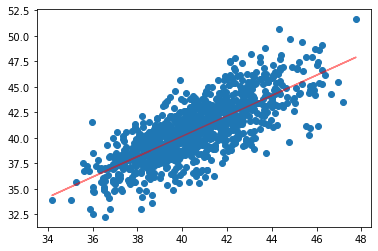

In [313]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)


In [314]:
#LDSC 
ldsc_res = run_ldsc(betas, ldsc_mask, n_ind/2.0)
print (sp.mean(ldsc_res['intercepts']))
print (sp.mean(ldsc_res['h2s']))
print (sp.mean(ldsc_res['slope']))

0.998373280674283
0.7969935623693036
0.07969935623693035


In [315]:
# Cs using p-val thresholded GWAS betas
c = sp.diag(betas_thres.T @ D @ betas_thres)
c_mask = sp.diag(betas_thres.T @ D_mask @ betas_thres)


[-0.00709717  1.00317159]


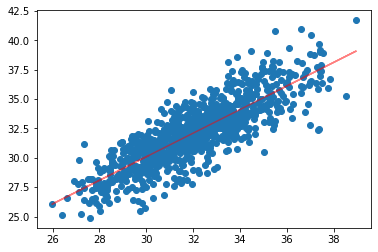

In [316]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)

In [317]:
#LDSC 
banded_res_t = run_ldsc(betas_thres, ldsc_mask, n_ind/2.0)
print (sp.mean(banded_res_t['intercepts']))
print (sp.mean(banded_res_t['h2s']))
print (sp.mean(banded_res_t['slope']))

0.7999460697826585
0.8294494671118116
0.08294494671118116


In [266]:
# Cs using true betas
c = sp.diag(betas_true @ D @ betas_true.T)
c_mask = sp.diag(betas_true @ D_mask @ betas_true.T)


[-0.01102291  1.01230737]


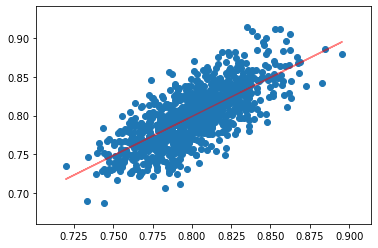

In [267]:
plt.show()
plt.scatter(c_mask,c)
ws = simp_lin_reg(c, c_mask)
print (ws)
plt.plot(c_mask, ws[1]*c_mask + ws[0],color='r',alpha=0.5)

In [268]:
#LDSC 
ldsc_res = run_ldsc(betas_true.T, ldsc_mask, n_ind)
print (sp.mean(ldsc_res['intercepts']))
print (sp.mean(ldsc_res['h2s']))
print (sp.mean(ldsc_res['slope']))

0.16017409339686667
-0.0002568202307977065
-5.136404615954132e-05
